In [22]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
from scipy.interpolate import griddata
from scipy.constants import convert_temperature as conv_temp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from controllers import ControllerBase
from controllers import PIDController
from controllers import PIDController_T_top
from controllers import LQRControllerDisc
from controllers import LQRControllerCont
from controllers import MPCController
from classes import LEDparams, Model
from system import Simulation

from img import save_plot2pdf

In [40]:
plot_neg_times    = False
plot_sim_plots    = False
save_sim_plots    = False

save_traj_plot    = True

### Choose the controller here:
# chosen_controller = 'PID'
chosen_controller = 'LQR'
# chosen_controller = 'MPC'

In [3]:
# PID
kp, ki, kd = -2.5, -4.0, 0.0
output_limits = (-3, 3)  # A

filename_pid = f"pid_kp_{kp:.1f}_ki_{ki:.1f}_kd_{kd:.1f}_lim_{output_limits[0]:.1f}_{output_limits[1]:.1f}"
filename_pid = filename_pid.replace(".0", "")
filename_pid = filename_pid.replace(".", "_")
print(filename_pid)

# LQR
q1 = 0
q2 = 25  # / (T_amb0**2)
q3 = 0
Q = np.array([[q1, 0, 0],
              [0, q2, 0],
              [0, 0, q3]])
r1 = 1
r2 = 1
R = np.array([[r1, 0],
              [0, r2]])

filename_lqr = f"lqr_q1_{q1:.1f}_q2_{q2:.1f}_q3_{q3:.1f}_r1_{r1:.1f}_r2_{r2:.1f}"
filename_lqr = filename_lqr.replace(".0", "")
filename_lqr = filename_lqr.replace(".", "_")
print(filename_lqr)

# MPC
q1_mpc = 0
q2_mpc = 1 / 40
q3_mpc = 0
Q_mpc  = np.array([[q1_mpc, 0,      0],
                   [0,      q2_mpc, 0],
                   [0,      0,      q3_mpc]])
S_mpc  = Q_mpc
r1_mpc = 1 / 3
r2_mpc = 1
R_mpc  = np.array([[r1_mpc, 0 ],
                   [0,      r2_mpc]])
prediction_horizon  = 20 # s
sampling_time       = 2  # s
discretization_time = 2  # s

pid_kp_-2_5_ki_-4_kd_0_lim_-3_3
lqr_q1_0_q2_25_q3_0_r1_1_r2_1


In [4]:
### Parameters
# Simulation
dt_sim = 1.0 # s
time_span = 60.0 * 20 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

# LED
LEDpar = LEDparams()
dimensions = LEDpar.dimensions

# Controller
dt_d = 2.0
T_cell_ref = conv_temp(37.0, 'C', 'K') # K

# Tracking
tracking_tol = 1 # °C or K

### Loop
## P_led_rad iterable variable
num_P_rad = 11
P_rad_vec = np.linspace(0.0, 1.0, num=num_P_rad)
# num_P_rad = 1
# P_rad_vec = np.linspace(0.2, 0.5, num=num_P_rad)

# ratio_decrease = 10 # decrease power of the LED by ... times compared to the maximum

# x_matrix_max = np.ones(dimensions) * (2**16 - 1) # max value for 16 bit resolution

# scale_factor = 1 / max(num_P_rad - 1, 1)  # Avoid division by zero for 1 trajectory
# x_matrix_norm_list = [x_matrix_max * traj * scale_factor / (2**16 - 1) / ratio_decrease 
#                       for traj in range(num_P_rad)]  # from min of zeros to max of ones corrected by the ratio_decrease
# # TODO implement program reader
# x_matrix = np.random.randint(0, 2**16-1, dimensions)
# x_matrix_scaled = x_matrix / (2**16-1) # duty cycle


## T_amb iterable variable
# num_T_amb = 8
# T_amb_vec = conv_temp(np.linspace(0.0, 74.0, num=num_T_amb), 'C', 'K') # K
# num_T_amb = 2
# T_amb_vec = conv_temp(np.linspace(25.0, 37.0, num=num_T_amb), 'C', 'K') # K
num_T_amb = 7
T_amb_vec = conv_temp(np.linspace(13.0, 49.0, num=num_T_amb), 'C', 'K') # K

In [5]:
## Start simulation loop
sim_results_list = []
leg_titles = []
sim_num = 0
for T_amb_iter in range(num_T_amb):
    for P_rad_iter in range(num_P_rad):
        # First iterable variable
        x_LED_tot, I_LED, P_rad = LEDpar.get_x_from_P_rad(P_rad_vec[P_rad_iter])

        # Second iterable variable
        T_amb = T_amb_vec[T_amb_iter]

        # Initial conditions
        x0 = np.array([0.9,
                       T_amb,
                       T_amb])

        # Model
        model = Model(LEDpar, x0, T_amb0=T_amb)

        T_top_ref = T_amb + (T_cell_ref - T_amb) * (model.R_top_cell + model.R_cell_amb) / model.R_cell_amb

        if chosen_controller == 'PID':
            controller_sim = PIDController_T_top(kp=kp, ki=ki, kd=kd,
                                                       T_top_ref=T_top_ref, T_cell_ref=T_cell_ref,
                                                       sampling_time=dt_d, output_limits=output_limits)
        elif chosen_controller == 'LQR':
            Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
            controller_sim = LQRControllerDisc(T_top_ref=T_top_ref, T_cell_ref=T_cell_ref, A_d=Ad, B_d=Bd, Q=Q, R=R, sampling_time=dt_d)

        elif chosen_controller == 'MPC':
            Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
            controller_sim = MPCController(model=model, T_top_ref=T_top_ref, T_cell_ref=T_cell_ref,
                                           A_d=Ad, B_d=Bd, h_d=hd, Q=Q_mpc, S=S_mpc, R=R_mpc,
                                           pred_time=prediction_horizon, sampling_time=sampling_time, discret_time=discretization_time,
                                           print_output=True, verbose=False)
        else:
            raise ValueError("Invalid controller.")

        # Simulation
        sim = Simulation(model=model, controller=controller_sim, dt_sim=dt_sim, time_span=time_span)

        # Run the simulation
        results = sim.run(with_initial_time=plot_neg_times, initial_time_span=10)
        
        # Check tracking condition
        current_is_tracking = abs(results["T_cell"].iloc[-1] - T_cell_ref) <= tracking_tol and all(abs(results["T_top"] - results["T_bot"]) <= model.DeltaT_max)

        results['tracked'] = current_is_tracking
        results['id_sim']  = sim_num
        results['P_rad_iter']   = P_rad_iter
        results['T_amb_iter']   = T_amb_iter
        sim_results_list.append(results)

        # Titles for legend and figures
        title_T_amb = r"$T_\mathrm{amb} =$" + f"{round(conv_temp(T_amb, 'K', 'C'))}°C"
        title_P_rad = r"$P_\mathrm{led,rad} =$" + f"{P_rad:.1f}W"
        
        # P_LED = np.mean(results["U_BT"].to_numpy()) * I_LED * x_LED_tot # W
        # title_P_LED = r"$P_\mathrm{LED} =$" + f"{P_LED:.1f}W"

        E_BT_tot = np.trapezoid(results["U_BT"].to_numpy() * results["I_BT"].to_numpy(), results["time"].to_numpy()) # J
        title_E_BT = r"$E_\mathrm{bt,tot} =$" + f"{E_BT_tot:.2f}J"

        fig_title = title_P_rad + "     " + title_E_BT + "     " + title_T_amb
        leg_title = title_P_rad + "," + title_T_amb

        leg_titles.append(leg_title)

        # Plot sim results and name the file in case of saving
        if plot_sim_plots:
            filename = f"T_amb_{round(conv_temp(T_amb, 'K', 'C'))}" + "_" + f"P_rad_{P_rad:.1f}W"
            filename = filename.replace(".", "_")

            sim.plot_time_results(fig_title, save_plot=save_sim_plots, filename=filename)
            sim.plot_current_temperature(fig_title, save_plot=save_sim_plots, filename=filename)

        # Increase counter
        sim_num = sim_num + 1

# All results
all_results_df = pd.concat(sim_results_list).set_index(['id_sim', 'P_rad_iter', 'T_amb_iter', 'time'])

In [6]:
# Calculate the power consumption
all_results_df["P_BT"] = all_results_df["I_BT"] * all_results_df["U_BT"]

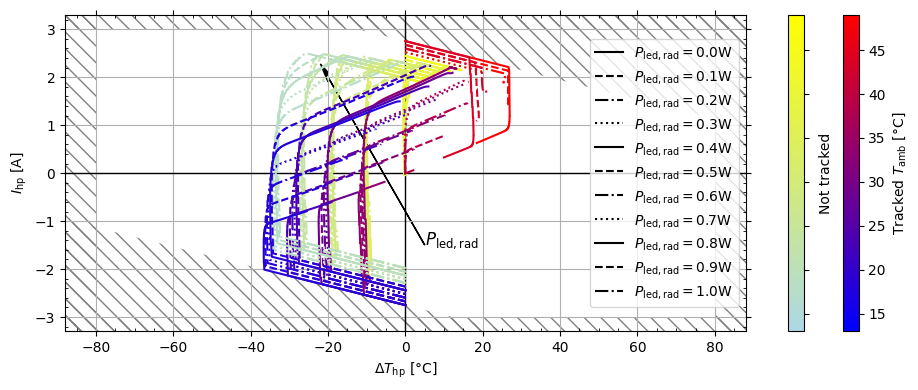

In [ ]:
## Colors
# Tracked coloring
color_gradient_T_amb = ["blue", "red"] # ["lightgray", "darkgray"]
cmap_tracked_T_amb   = LinearSegmentedColormap.from_list("temperature_scale", color_gradient_T_amb)

# Not tracked coloring
# grays = ["#D3D3D3", "#696969"] # ["lightgray", "darkgray"]
grays_gradient_T_amb = ["lightblue", "yellow"]
cmap_untracked_T_amb = LinearSegmentedColormap.from_list("gray_scale", grays_gradient_T_amb)

# T_amb_vec = conv_temp(np.linspace(-70.0, 70.0, num=num_T_amb), 'C', 'K') # K
norm_tracked_T_amb   = Normalize(vmin=conv_temp(T_amb_vec[0], 'K', 'C'), vmax=conv_temp(T_amb_vec[-1], 'K', 'C'))
norm_untracked_T_amb = Normalize(vmin=conv_temp(T_amb_vec[0], 'K', 'C'), vmax=conv_temp(T_amb_vec[-1], 'K', 'C'))

color_gradient_P_rad = ["green", "orange"]
cmap_tracked_P_rad   = LinearSegmentedColormap.from_list("temperature_scale", color_gradient_P_rad)
norm_tracked_P_rad   = Normalize(vmin=P_rad_vec[0], vmax=P_rad_vec[-1])

# Types of lines
P_rad_lin_style = ["-", "--", "-.", ":"]

sim_len = sim.time_steps


# Voltage constraints
_, _, _ = LEDpar.get_x_from_P_rad(P_rad_vec[0])
model = Model(LEDpar, x0, T_amb0=T_amb)

x_vec = np.linspace(-100, 100, sim_len)
y_vec_min, y_vec_max = model.get_constraints_U_BT2I_HP(x_vec)

### Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.axhline(y=0, lw=1, color='black', label='_nolegend_')
ax.axvline(x=0, lw=1, color='black', label='_nolegend_')

# Constraints
x_lim_max = model.DeltaT_max * 1.1
y_lim_max = model.I_HP_max * 1.1

fill_color = 'gray'
fill_alpha = 0.1
hatch_style = '\\\\'

ax.plot(x_vec, y_vec_max, color='gray', label='_nolegend_')
# ax.fill_between(x_vec, y_vec_max, y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, y_vec_max, y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.plot(x_vec, y_vec_min, color='gray', label='_nolegend_')
# ax.fill_between(x_vec, y_vec_min, -y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, y_vec_min, -y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axhline(y=model.I_HP_max, color='gray', label='_nolegend_')
# ax.fill_between(x_vec, model.I_HP_max, y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, model.I_HP_max, y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axhline(y=-model.I_HP_max, color='gray', label='_nolegend_')
# ax.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axvline(x=model.DeltaT_max, color='gray', label='_nolegend_')
# ax.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axvline(x=-model.DeltaT_max, color='gray', label='_nolegend_')
# ax.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# Lines for legend
for i, P_rad in enumerate(P_rad_vec):
    ax.plot([], [], linestyle=P_rad_lin_style[i % len(P_rad_lin_style)], color='black', label=r'$P_\mathrm{led,rad} = $' + f'{P_rad:.1f}W')

# Group by id_sim
for sim_id, group in reversed(list(all_results_df.groupby(level='id_sim'))):
    # Compute x and y values for this trajectory
    x_sim = group["T_bot"].to_numpy() - group["T_top"].to_numpy()
    y_sim = group["I_HP"].to_numpy()

    # Line style based on P_rad
    line_style = P_rad_lin_style[group.index.get_level_values('P_rad_iter')[0] % len(P_rad_lin_style)]

    # Colormap based on tracking
    cmap = cmap_tracked_T_amb if group["tracked"].iloc[0] else cmap_untracked_T_amb

    # Entry of the colormap depending on T_amb
    T_amb_i = group.index.get_level_values('T_amb_iter')[0]
    frac_color = (T_amb_i + 1) / num_T_amb
    traj_color = cmap(frac_color)

    ax.plot(x_sim, y_sim, linestyle=line_style, color=traj_color, label='_nolegend_')

# Add the colorbars
cbar_tracked = fig.colorbar(plt.cm.ScalarMappable(norm=norm_tracked_T_amb, cmap=cmap_tracked_T_amb), ax=ax, location='right', pad=-0.08)
cbar_tracked.set_label(r'Tracked $T_\mathrm{amb}$ [°C]')

cbar_untracked = fig.colorbar(plt.cm.ScalarMappable(norm=norm_untracked_T_amb, cmap=cmap_untracked_T_amb), ax=ax, location='right')
cbar_untracked.ax.set_yticklabels([])
cbar_untracked.set_label(r'Not tracked')

# Arrow
start_x, start_y = 5, -1.5
end_x, end_y = -20, 2

ax.arrow(start_x, start_y,
         end_x - start_x, end_y - start_y,
         head_width=0.2, head_length=2, fc='black', ec='black')
ax.text(start_x, start_y, r'$P_\mathrm{led,rad}$', fontsize=12, ha='left', color='black')

ax.set_xlim(-model.DeltaT_max * 1.1, model.DeltaT_max * 1.1)
ax.set_ylim(-model.I_HP_max * 1.1, model.I_HP_max * 1.1)
ax.set_xlabel(r'$\Delta T_\mathrm{hp}$ [°C]')
ax.set_ylabel(r'$I_\mathrm{hp}$ [A]')
# ax.set_title('Current-Temperature Phase Space')
ax.legend()
ax.grid()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='x', which='minor', direction='in', top=True)
ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)
ax.tick_params(axis='x', which='major', top=True)
ax.tick_params(axis='y', which='major', left=True, right=True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tight_layout()

# if save_traj_plot:
#     in_fln = "I_DT_traj"
#     filename = f"{in_fln}_{filename_pid}" if chosen_controller == 'PID' else f"{in_fln}_{filename_lqr}"
#     save_plot2pdf(filename, fig)
plt.show()

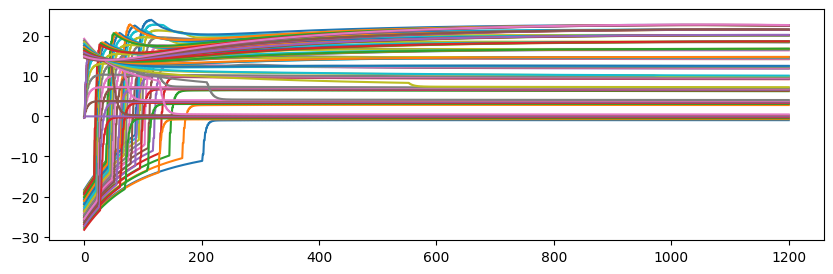

In [15]:
# Plot all Q_top
fig, ax = plt.subplots(figsize=(10, 3))

for sim_id, group in all_results_df.groupby(level='id_sim'):
    ax.plot(group["Q_top"].to_numpy())

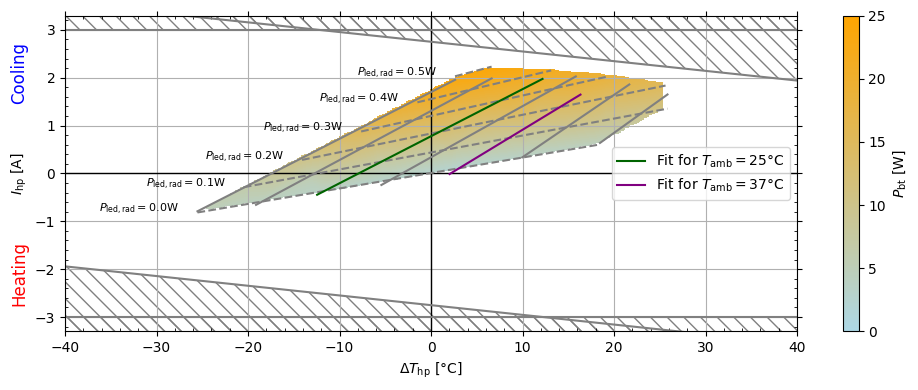

In [17]:

## Colors
color_gradient_P_bt = ["lightblue", "orange"]
cmap_tracked_P_bt = LinearSegmentedColormap.from_list("P_bt_scale", color_gradient_P_bt)
# norm_tracked_P_bt = Normalize(vmin=0, vmax=25)


### Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.axhline(y=0, lw=1, color='black', label='_nolegend_')
ax.axvline(x=0, lw=1, color='black', label='_nolegend_')

# Constraints
x_lim_max = model.DeltaT_max * 1.1
y_lim_max = model.I_HP_max * 1.1

line_color = 'gray'
fill_color = 'gray'
fill_alpha = 0.1
hatch_style = '\\\\'

ax.plot(x_vec, y_vec_max, color=line_color, label='_nolegend_')
# ax.fill_between(x_vec, y_vec_max, y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, y_vec_max, y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.plot(x_vec, y_vec_min, color=line_color, label='_nolegend_')
# ax.fill_between(x_vec, y_vec_min, -y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, y_vec_min, -y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axhline(y=model.I_HP_max, color=line_color, label='_nolegend_')
# ax.fill_between(x_vec, model.I_HP_max, y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, model.I_HP_max, y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axhline(y=-model.I_HP_max, color=line_color, label='_nolegend_')
# ax.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axvline(x=model.DeltaT_max, color=line_color, label='_nolegend_')
# ax.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axvline(x=-model.DeltaT_max, color=line_color, label='_nolegend_')
# ax.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# Container for contourf
P_bt_list = []

# Iterate over P_rad and plot regression lines
for P_rad_iter, group in all_results_df.groupby(level='P_rad_iter'):
    x_end_P_rad = []
    y_end_P_rad = []
    for P_led_iter, sub_group in group.groupby(level='T_amb_iter'):
        if sub_group["tracked"].iloc[0]:
            # Use last values in the sub-group for fitting
            x_end = sub_group["T_bot"].to_numpy()[-1] - sub_group["T_top"].to_numpy()[-1]
            y_end = sub_group["I_HP"].to_numpy()[-1]
            z_end = sub_group["P_BT"].to_numpy()[-1]

            x_end_P_rad.append(x_end)
            y_end_P_rad.append(y_end)
            P_bt_list.append([x_end, y_end, z_end])

    # Perform least-squares
    if x_end_P_rad and y_end_P_rad:  # Ensure there are data points to fit
        poly_model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
        x_end_P_rad_reshaped = np.array(x_end_P_rad)[:, np.newaxis]
        poly_model.fit(x_end_P_rad_reshaped, np.array(y_end_P_rad))

        # Generate points for the fitted curve
        x_fit = np.linspace(min(x_end_P_rad), max(x_end_P_rad), 100)
        y_fit = poly_model.predict(x_fit[:, np.newaxis])

        # Line properties
        P_rad = P_rad_vec[P_rad_iter]
        line_color = 'gray'
        fit_label = '__no_label__'
        fit_text = f'$P_\mathrm{{led,rad}} =${P_rad:.1f}W'
        
        # Plot the fitted curve
        ax.plot(x_fit, y_fit, linestyle="--", color=line_color, label=fit_label)
        
        ax.text(x_fit[0]-1, y_fit[0], fit_text, fontsize=8, ha='right', color='black')

# Iterate over T_amb and plot regression lines
for T_amb_iter, group in all_results_df.groupby(level='T_amb_iter'):
    x_end_T_amb = []
    y_end_T_amb = []
    for P_led_iter, sub_group in group.groupby(level='P_rad_iter'):
        if sub_group["tracked"].iloc[0]:
            # Use last values in the sub-group for fitting
            x_end = sub_group["T_bot"].to_numpy()[-1] - sub_group["T_top"].to_numpy()[-1]
            y_end = sub_group["I_HP"].to_numpy()[-1]
            z_end = sub_group["P_BT"].to_numpy()[-1]

            x_end_T_amb.append(x_end)
            y_end_T_amb.append(y_end)
            P_bt_list.append([x_end, y_end, z_end])

    # Perform least-squares
    if len(x_end_T_amb) > 1 and len(y_end_T_amb) > 1:  # Ensure there are at least 2 data points to fit
        poly_model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
        x_end_reshaped = np.array(x_end_T_amb)[:, np.newaxis]
        poly_model.fit(x_end_reshaped, np.array(y_end_T_amb))

        # Generate points for the fitted curve
        x_fit = np.linspace(min(x_end_T_amb), max(x_end_T_amb), 100)
        y_fit = poly_model.predict(x_fit[:, np.newaxis])

        # Determine line color based on T_amb
        T_amb_C = conv_temp(T_amb_vec[T_amb_iter], "K", "C")
        if T_amb_C == 25:
            line_color = 'darkgreen'
            fit_label = r'Fit for $T_\mathrm{amb} =$' + f'{round(T_amb_C)}°C'
        elif T_amb_C == 37:
            line_color = 'purple'
            fit_label = r'Fit for $T_\mathrm{amb} =$' + f'{round(T_amb_C)}°C'
        else:
            line_color = 'gray'
            fit_label = '__no_label__'
        
        # Plot the fitted curve
        ax.plot(x_fit, y_fit, linestyle="-", color=line_color, label=fit_label)

# Contourf for power consumption
P_bt_vec = np.array(P_bt_list)
x, y, P_bt = P_bt_vec[:, 0], P_bt_vec[:, 1], P_bt_vec[:, 2]

norm_tracked_P_bt = Normalize(vmin=0, vmax=math.ceil(max(P_bt)))

# Create a meshgrid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the P_bt values onto the grid
grid_P_bt = griddata((x, y), P_bt, (grid_x, grid_y), method='linear')

ax.contourf(grid_x, grid_y, grid_P_bt, levels=100, cmap=cmap_tracked_P_bt, norm=norm_tracked_P_bt)

# Add the colorbars
cbar_P_bt = fig.colorbar(plt.cm.ScalarMappable(norm=norm_tracked_P_bt, cmap=cmap_tracked_P_bt), ax=ax, location='right')
cbar_P_bt.set_label(r'$P_\mathrm{bt}$ [W]')

# Adjust plot limits and labels
x_limits = (-40, 40)
# ax.set_xlim(-model.DeltaT_max * 1.1, model.DeltaT_max * 1.1)
ax.set_xlim(x_limits)
ax.set_ylim(-model.I_HP_max * 1.1, model.I_HP_max * 1.1)
ax.set_xlabel(r'$\Delta T_\mathrm{hp}$ [°C]')
ax.set_ylabel(r'$I_\mathrm{hp}$ [A]')
ax.text(x_limits[0]-5,  2.1, "Cooling", fontsize=12, ha='center', va='center', rotation=90, color='blue')
ax.text(x_limits[0]-5, -2.1, "Heating", fontsize=12, ha='center', va='center', rotation=90, color='red')
ax.legend()
ax.grid()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='x', which='minor', direction='in', top=True)
ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)
ax.tick_params(axis='x', which='major', top=True)
ax.tick_params(axis='y', which='major', left=True, right=True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tight_layout()

if save_T_amb_plot:
    # Generate filename dynamically
    in_fln = "I_DT_fitTamb"
    filename = f"{in_fln}_{filename_pid}" if chosen_controller == 'PID' else f"{in_fln}_{filename_lqr}"
    save_plot2pdf(filename, fig)
plt.show()


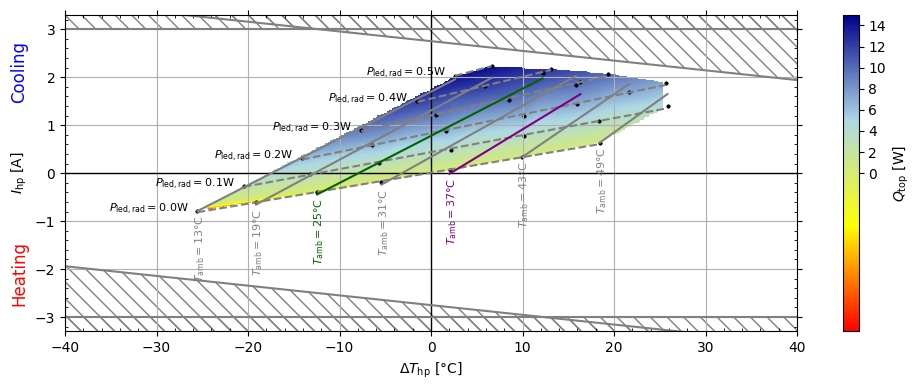

In [42]:

## Colors
color_gradient_Q_top = ["red", "yellow", "lightblue", "darkblue"]
cmap_tracked_Q_top = LinearSegmentedColormap.from_list("Q_top_scale", color_gradient_Q_top)

### Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.axhline(y=0, lw=1, color='black', label='_nolegend_')
ax.axvline(x=0, lw=1, color='black', label='_nolegend_')

# Constraints
x_lim_max = model.DeltaT_max * 1.1
y_lim_max = model.I_HP_max * 1.1

line_color = 'gray'
fill_color = 'gray'
fill_alpha = 0.1
hatch_style = '\\\\'

ax.plot(x_vec, y_vec_max, color=line_color, label='_nolegend_')
# ax.fill_between(x_vec, y_vec_max, y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, y_vec_max, y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.plot(x_vec, y_vec_min, color=line_color, label='_nolegend_')
# ax.fill_between(x_vec, y_vec_min, -y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, y_vec_min, -y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axhline(y=model.I_HP_max, color=line_color, label='_nolegend_')
# ax.fill_between(x_vec, model.I_HP_max, y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, model.I_HP_max, y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axhline(y=-model.I_HP_max, color=line_color, label='_nolegend_')
# ax.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axvline(x=model.DeltaT_max, color=line_color, label='_nolegend_')
# ax.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

ax.axvline(x=-model.DeltaT_max, color=line_color, label='_nolegend_')
# ax.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color=fill_color, alpha=fill_alpha, label='_nolegend_')
ax.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color='none', hatch=hatch_style, edgecolor=fill_color, linewidth=0, label='_nolegend_')

# Container for contourf
Q_top_list = []

# Iterate over P_rad and plot regression lines
for P_rad_iter, group in all_results_df.groupby(level='P_rad_iter'):
    x_end_P_rad = []
    y_end_P_rad = []
    for P_led_iter, sub_group in group.groupby(level='T_amb_iter'):
        if sub_group["tracked"].iloc[0]:
            # Use last values in the sub-group for fitting
            x_end = sub_group["T_bot"].to_numpy()[-1] - sub_group["T_top"].to_numpy()[-1]
            y_end = sub_group["I_HP"].to_numpy()[-1]
            # z_end = sub_group["P_BT"].to_numpy()[-1]
            z_end = sub_group["Q_top"].to_numpy()[-1]

            x_end_P_rad.append(x_end)
            y_end_P_rad.append(y_end)
            Q_top_list.append([x_end, y_end, z_end])

    # Perform least-squares
    if x_end_P_rad and y_end_P_rad:  # Ensure there are data points to fit
        poly_model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
        x_end_P_rad_reshaped = np.array(x_end_P_rad)[:, np.newaxis]
        poly_model.fit(x_end_P_rad_reshaped, np.array(y_end_P_rad))

        # Generate points for the fitted curve
        x_fit = np.linspace(min(x_end_P_rad), max(x_end_P_rad), 100)
        y_fit = poly_model.predict(x_fit[:, np.newaxis])

        # Line properties
        P_rad = P_rad_vec[P_rad_iter]
        line_color = 'gray'
        fit_label = '__no_label__'
        fit_text = f'$P_\mathrm{{led,rad}} =${P_rad:.1f}W'
        
        # Plot the fitted curve
        ax.plot(x_fit, y_fit, linestyle="--", color=line_color, label=fit_label)
        
        ax.text(x_fit[0]-1, y_fit[0], fit_text, fontsize=8, ha='right', color='black')

# Iterate over T_amb and plot regression lines
for T_amb_iter, group in all_results_df.groupby(level='T_amb_iter'):
    x_end_T_amb = []
    y_end_T_amb = []
    for P_led_iter, sub_group in group.groupby(level='P_rad_iter'):
        if sub_group["tracked"].iloc[0]:
            # Use last values in the sub-group for fitting
            x_end = sub_group["T_bot"].to_numpy()[-1] - sub_group["T_top"].to_numpy()[-1]
            y_end = sub_group["I_HP"].to_numpy()[-1]
            # z_end = sub_group["P_BT"].to_numpy()[-1]
            z_end = sub_group["Q_top"].to_numpy()[-1]

            x_end_T_amb.append(x_end)
            y_end_T_amb.append(y_end)
            Q_top_list.append([x_end, y_end, z_end])

    # Perform least-squares
    if len(x_end_T_amb) > 1 and len(y_end_T_amb) > 1:  # Ensure there are at least 2 data points to fit
        poly_model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
        x_end_reshaped = np.array(x_end_T_amb)[:, np.newaxis]
        poly_model.fit(x_end_reshaped, np.array(y_end_T_amb))

        # Generate points for the fitted curve
        x_fit = np.linspace(min(x_end_T_amb), max(x_end_T_amb), 100)
        y_fit = poly_model.predict(x_fit[:, np.newaxis])

        # Determine line color based on T_amb
        T_amb_C = conv_temp(T_amb_vec[T_amb_iter], "K", "C")

        fit_text = r'$T_\mathrm{amb} =$' + f'{round(T_amb_C)}°C'

        if T_amb_C == 25:
            line_color = 'darkgreen'
            fit_label = r'Fit for $T_\mathrm{amb} =$' + f'{round(T_amb_C)}°C'
        elif T_amb_C == 37:
            line_color = 'purple'
            fit_label = r'Fit for $T_\mathrm{amb} =$' + f'{round(T_amb_C)}°C'
        else:
            line_color = 'gray'
            fit_label = '__no_label__'
        
        # Plot the fitted curve
        ax.plot(x_fit, y_fit, linestyle="-", color=line_color, label=fit_label)
        ax.text(x_fit[0]+1, y_fit[0]-1.4, fit_text, fontsize=8, ha='right', color=line_color, rotation=90)

# Contourf for power consumption
Q_top_vec = np.array(Q_top_list)
x, y, Q_top = Q_top_vec[:, 0], Q_top_vec[:, 1], Q_top_vec[:, 2]

# norm_tracked_Q_top = Normalize(vmin=math.floor(min(Q_top)), vmax=math.ceil(max(Q_top)))
norm_tracked_Q_top = TwoSlopeNorm(vmin=math.floor(min(Q_top)), vcenter=0, vmax=math.ceil(max(Q_top)))

# Create a meshgrid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Q_top values onto the grid
grid_Q_top = griddata((x, y), Q_top, (grid_x, grid_y), method='linear')

ax.contourf(grid_x, grid_y, grid_Q_top, levels=100, cmap=cmap_tracked_Q_top, norm=norm_tracked_Q_top)
ax.scatter(x, y, color='black', s=3)

# Add the colorbars
cbar_Q_top = fig.colorbar(plt.cm.ScalarMappable(norm=norm_tracked_Q_top, cmap=cmap_tracked_Q_top), ax=ax, location='right')
cbar_Q_top.set_label(r'$Q_\mathrm{top}$ [W]')

# Adjust plot limits and labels
x_limits = (-40, 40)
# ax.set_xlim(-model.DeltaT_max * 1.1, model.DeltaT_max * 1.1)
ax.set_xlim(x_limits)
ax.set_ylim(-model.I_HP_max * 1.1, model.I_HP_max * 1.1)
ax.set_xlabel(r'$\Delta T_\mathrm{hp}$ [°C]')
ax.set_ylabel(r'$I_\mathrm{hp}$ [A]')
ax.text(x_limits[0]-5,  2.1, "Cooling", fontsize=12, ha='center', va='center', rotation=90, color='blue')
ax.text(x_limits[0]-5, -2.1, "Heating", fontsize=12, ha='center', va='center', rotation=90, color='red')
# ax.legend()
ax.grid()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='x', which='minor', direction='in', top=True)
ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)
ax.tick_params(axis='x', which='major', top=True)
ax.tick_params(axis='y', which='major', left=True, right=True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tight_layout()

if save_traj_plot:
    # Generate filename dynamically
    in_fln = "I_DT_traj"
    filename = f"{in_fln}_{filename_pid}" if chosen_controller == 'PID' else f"{in_fln}_{filename_lqr}"
    save_plot2pdf(filename, fig)
plt.show()


In [26]:
math.floor(min(Q_top))

-1

In [19]:
# import phaseportrait as pp
# # Continuous Open-Loop
# # Nonlinear phase portrait
# def f_nonlinear(Tc, Th):
#     u = model.get_operational_input
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = model.dynamics_f(x, u)
#     return x_[1], x_[2]

# # Linear phase portrait
# def f_linear(Tc, Th):
#     u = model.get_operational_input
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = A @ x + B @ u + h
#     return x_[1], x_[2]

# # Closed-Loop
# # Linear phase portrait
# def f_linear_cl(Tc, Th):
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = (A - B @ lqr_controller.K) @ x + h
#     return x_[1], x_[2]

# # Plot
# # Nonlinear Phase Portrait
# pp_nonlinear_op = pp.PhasePortrait2D(f_nonlinear, [-50, 50], Title='Continuous Nonlinear Open-Loop', xlabel=r"$T_top$", ylabel=r"$T_bot$")
# pp_nonlinear_op.plot()

# # Linear Phase Portrait
# pp_linear_op = pp.PhasePortrait2D(f_linear, [-50, 50], Title='Continuous Linear Open-Loop', xlabel=r"$T_top$", ylabel=r"$T_bot$")
# pp_linear_op.plot()

# # Linear Phase Portrait closed-loop
# pp_linear_cl = pp.PhasePortrait2D(f_linear_cl, [100, 300], Title='Continuous Linear Closed-Loop', xlabel=r"$T_top$", ylabel=r"$T_bot$")
# pp_linear_cl.plot()

In [20]:
# x_FAN = 1.0
# x_SoC = 0.85
# I_HP = 1.2

# lenght_data = 10

# # Define the system of equations dTh/dt = f3(Th, Tc) and dTc/dt = f2(Th, Tc)
# def f3(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
#     tmp = np.zeros_like(Th)

#     for i in range(lenght_data):
#         tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[2]

#     return tmp

# def f2(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
#     tmp = np.zeros_like(Th)

#     for i in range(lenght_data):
#         tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[1]

#     return tmp

# Th_sim = results["T_bot"].to_numpy()
# Tc_sim = results["T_top"].to_numpy()

# # Create a grid of points in the (x, y) plane
# x = np.linspace(Th_sim.min()-abs(Th_sim.min())*0.1, Th_sim.max()+abs(Th_sim.max())*0.1, lenght_data)
# y = np.linspace(Tc_sim.min()-abs(Tc_sim.min())*0.1, Tc_sim.max()+abs(Tc_sim.max())*0.1, lenght_data)
# X, Y = np.meshgrid(x, y)

# # Compute the vector field at each grid point
# u = f3(x, y)
# v = f2(x, y)
# U, V = np.meshgrid(u, v)

# # Plot the streamlines using the quiver function
# plt.figure(figsize=(10, 3))
# plt.quiver(X, Y, U, V, color='g')  # Arrows indicating the direction field
# plt.plot(Th_sim, Tc_sim, color='r')
# plt.plot(conv_temp(T_amb0, 'K', 'C'), conv_temp(T_amb0, 'K', 'C'), 'o', color='black', label='Ambient')
# plt.xlabel(r"$T_\mathrm{h}$ [°C]")
# plt.ylabel(r"$T_\mathrm{c}$ [°C]")
# plt.title('Temperature Phase Portrait')

# # Additionally, plot using streamplot for smoother visualization
# plt.streamplot(X, Y, U, V, color='b', linewidth=1)

# plt.grid()
# plt.show()